## Benchmarks



In [147]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import os
import math
from tqdm import tqdm
from ornet.cells_to_gray import vid_to_gray
import shutil

In [148]:
from ornet.pipeline import compute_gmm_intermediates, compute_distances

In [149]:
my_path = '/Users/ram/dev/quinn/ornet-data/ornet-outputs'

In [150]:
class_labels = ['control', 'llo', "mdivi"]
label_dict = {'control':0, 'llo':1, "mdivi":2}

In [151]:
class DistancesDataset(Dataset):
    def __init__(self, path_to_folder):
        self.graphs = []
        self.labels= []
        self.vid_names=[]
        
        for label in class_labels:
            path = os.path.join(path_to_folder, label)
            print(path)
            files = os.listdir(path)
            for file_name in files:
                    if file_name.split('.')[-1] in ['npy']:
#                         print(file_names)
                        self.labels.append(label_dict[label])
                        self.graphs.append(np.load(os.path.join(path, file_name)))
                        self.vid_names.append(file_name.split('.')[0])
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        graph = self.graphs[idx]
        return graph, label
#         sample = {"Graph": graph, "Class": label}
#         return sample

In [152]:
path_to_distances = os.path.join(my_path, 'distances')
graph_dataset = DistancesDataset(path_to_distances)

/Users/ram/dev/quinn/ornet-data/ornet-outputs/distances/control
/Users/ram/dev/quinn/ornet-data/ornet-outputs/distances/llo
/Users/ram/dev/quinn/ornet-data/ornet-outputs/distances/mdivi


In [153]:
g, l = next(iter(graph_dataset))
g.shape

(200, 27, 27)

In [154]:
class SinglesDataset(Dataset):
    def __init__(self, path_to_folder, vid_names=None, frame_idx=0):
        self.labels= []
        self.vid_path = []
        self.frame_idx= frame_idx
        
        print(path_to_folder)
        
        
        # specify certain videos by their file name
        if vid_names: # has items
            name_constraint = lambda x: x.split('.')[0] in vid_names
        else:
            name_constraint = lambda x: 'normalized' in x
     
        for label in class_labels:
            path = os.path.join(path_to_folder, label)
            files = os.listdir(path)
            for file_name in files:
                    if  name_constraint(file_name):
                        self.vid_path.append(os.path.join(path, file_name))
                        self.labels.append(label_dict[label])

    def __len__(self):
        return len(self.labels)

    
    def __getitem__(self, idx):
        # do we need to load the whole video to get the 2 frames
        label = self.labels[idx]
        vid = np.load(self.vid_path[idx])
        path = self.vid_path[idx]
        return vid[0], vid[-1], label, path # added file path cause I'm looking back over issues in data
    
 #         return vid[self.frame_idx], label

In [184]:
"""
The gray-singles folder contains single cell video files in .npy format.
The original videos contained multiple cell's, each was extracted into its own video.
The pixel intensity has been normalized across vids, and converted to gray-scale.
The 24 videos were sampled to yield like 100-200 frames, we don't care at this point because we will only look
at the first and last frames of the video.

We start off with 149 videos, but some are dropped due to errors as they move through the ornet pipeline.
If you only want to examine the 114 input videos that successfuly make it through the pipeline, add 
a list of the succesful filenames, on this notebook you can do
                `SinglesDataset(path_to_singles, graphs_dataset.vid_names)`
"""

path_to_singles = os.path.join(my_path, "gray-frame-pairs") # i swear it is grey not gray been i've brainwashed by the brits

# path_to_singles = my_path + "/singles"
# some of the videos did non succeed beyond the gmm, 114/149 originals I believe

singles_data = SinglesDataset(path_to_singles) # all 149 normalized videos
# singles_data = SinglesDataset(path_to_singles, vid_names=graphs_dataset.vid_names) # videos that make it to end of pipeline

print(len(singles_data), "samples")


# I don't remember if these should be two different datasets. if so change the return in getItem
# first_frame_data = SinglesDataset(path_to_singles, frame_idx=0)
# last_frame_data = SinglesDataset(path_to_singles, frame_idx=-1)



/Users/ram/dev/quinn/ornet-data/ornet-outputs/gray-frame-pairs
149 samples


From group control
/Users/ram/dev/quinn/ornet-data/ornet-outputs/gray-frame-pairs/control/HeLa-DsRed2_10_13_normalized_1.npy


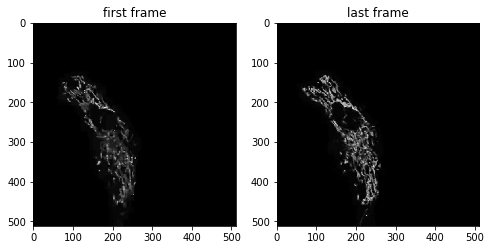

In [185]:
figure = plt.figure(figsize=(8, 8))
sample_idx = torch.randint(len(singles_data), size=(1,)).item()

img1, img2, label, file = singles_data[sample_idx]
#     img, label = training_data[sample_idx]

print("From group", class_labels[label])
print(file)
figure.add_subplot(1,2,1)
plt.title("first frame")
# plt.axis("off")
plt.imshow(img1.squeeze(), cmap="gray")

figure.add_subplot(1,2,2)
plt.title("last frame")
plt.imshow(img2.squeeze(), cmap="gray")

plt.show()

### noticing some wacky data along the way

From group LLO


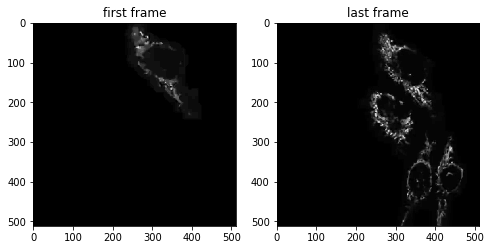

In [188]:
# uh oh singles data is not singles data
figure = plt.figure(figsize=(8, 8))
sample = np.load(my_path + "/gray-singles/llo/DsRed2-HeLa_11_2_LLO_normalized_9.npy")

print("From group LLO")

figure.add_subplot(1,2,1)
plt.title("first frame")
plt.imshow(sample[0].squeeze(), cmap="gray")
figure.add_subplot(1,2,2)
plt.title("last frame")
plt.imshow(sample[-1].squeeze(), cmap="gray")

From group LLO


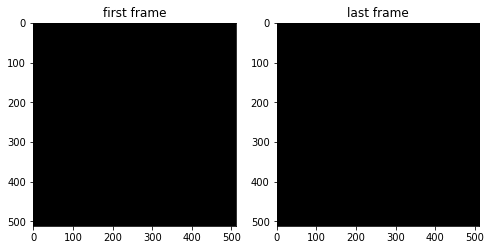

False

In [187]:
# any data there?
figure = plt.figure(figsize=(8, 8))
sample = np.load(my_path + "/gray-singles/llo/DsRed2-HeLa_11_2_LLO_normalized_5.npy")

print("From group LLO")

figure.add_subplot(1,2,1)
plt.title("first frame")
plt.imshow(sample[0].squeeze(), cmap="gray")
figure.add_subplot(1,2,2)
plt.title("last frame")
plt.imshow(sample[-1].squeeze(), cmap="gray")
plt.show()

# nope just 0's
np.any((sample[0] != 0.0))